In [1]:
from DataSet import DataSet

Loading ml-1m data set...
Loading Success!
Data Info:
	User Num: 6040
	Item Num: 3952
	Data Size: 1000209


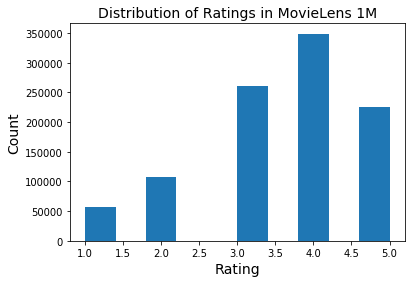

In [2]:
filepath = './Data/ml-1m/ratings.dat'
a = DataSet(filepath)

In [3]:
a.shape[0]

6040

In [3]:
import numpy as np
import pandas as pd


In [5]:
df = pd.DataFrame(a.data, columns=['user', 'item', 'ratings', 'time'])
df = df.drop(columns=['time'])

In [4]:
filename = './Data/ml-1m/u.data'
name = ['user', 'item', 'ratings', 'time']
df1 = pd.read_csv(filename, sep='\t', names = name)
df1 = df1.drop(columns=['time'])

In [5]:
data_dim = len(df1.user.unique()), len(df1.item.unique())

In [6]:
data_dim[0]

943

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
data = np.array(df1)
train, test = train_test_split(data, test_size=0.2)

In [9]:
u_train = train[:,0]
i_train = train[:,1]
r_train = train[:,2]
u_test = test[:,0]
i_test = test[:,1]
r_test = test[:,2]

In [6]:
shuffled_ratings = df.sample(frac = 1.)
Users = shuffled_ratings['user'].values
print ('Users:', Users, ', shape =', Users.shape)
Movies = shuffled_ratings['item'].values
print ('Movies:', Movies, ', shape =', Movies.shape)
Ratings = shuffled_ratings['ratings'].values
print ('Ratings:', Ratings, ', shape =', Ratings.shape)

Users: [3646 5656 4051 ... 3453  662  659] , shape = (1000209,)
Movies: [2985  213 2797 ... 1294  410 2145] , shape = (1000209,)
Ratings: [4. 5. 2. ... 4. 4. 3.] , shape = (1000209,)


In [10]:
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.layers import dot, concatenate, Embedding, Input, Flatten, Dropout, Dense,Conv1D
from keras.models import Sequential
from keras import optimizers

Using TensorFlow backend.


In [11]:
len_dim_i = [64,128,128,256,512]
len_dim_u = [64,128,128,256,512]
len_dim_r = [1024,512,512,256,256,128]

In [11]:
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

user_embedding = Embedding(output_dim=10, input_dim=data_dim[0] + 1,
                                   input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=10, input_dim=data_dim[1] + 1,
                                   input_length=1, name='item_embedding')(item_id_input)

user_vecs = (Dense(10))(user_embedding)
item_vecs = (Dense(10))(item_embedding)

# reshape from shape: (batch_size, input_length, embedding_size)
# to shape: (batch_size, input_length * embedding_size) which is
# equal to shape: (batch_size, embedding_size)
    

user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

    
# y = merge([user_vecs, item_vecs], mode='dot', output_shape=(1,))
y = dot([user_vecs, item_vecs], axes=1)
for i in range(len(len_dim_r)):
    y = (Dense(len_dim_r[i]))(y)
    y = (Dropout(0.25))(y)
# y = Dense(1, activation="relu")(y)
# M = Sequential()
# M.add(y)
y = (Dropout(0.4))(y)
y = (Dense(64))(y)
# y = (Dropout(0.2))(y)
y = (Dense(32))(y)
# y = (Dropout(0.2))(y)
# y = (Dense(16))(y)
# y = (Dropout(0.2))(y)
y = (Dense(4))(y)
y = (Dense(1, activation='relu'))(y)

model = Model(inputs=[user_id_input, item_id_input], outputs=[y])
adam = optimizers.Adam(lr=0.001)
model.compile(optimizer=adam, loss='mae',metrics=['accuracy', 'mae'])

In [12]:
history = model.fit([u_train,i_train], r_train,validation_data=([u_test,i_test], r_test), batch_size=64, epochs = 5, verbose=1)

Train on 80000 samples, validate on 20000 samples
Epoch 1/5
80000/80000 [==============================] - 41s 507us/step - loss: 0.9472 - acc: 0.3257 - mean_absolute_error: 0.9472 - val_loss: 0.9193 - val_acc: 0.3442 - val_mean_absolute_error: 0.9193
Epoch 2/5
80000/80000 [==============================] - 41s 507us/step - loss: 0.9051 - acc: 0.3411 - mean_absolute_error: 0.9051 - val_loss: 0.8919 - val_acc: 0.3442 - val_mean_absolute_error: 0.8919
Epoch 3/5
80000/80000 [==============================] - 42s 527us/step - loss: 0.8912 - acc: 0.3503 - mean_absolute_error: 0.8912 - val_loss: 0.8488 - val_acc: 0.3604 - val_mean_absolute_error: 0.8488
Epoch 4/5
80000/80000 [==============================] - 43s 540us/step - loss: 0.7727 - acc: 0.4154 - mean_absolute_error: 0.7727 - val_loss: 0.8234 - val_acc: 0.3775 - val_mean_absolute_error: 0.8234
Epoch 5/5
80000/80000 [==============================] - 42s 530us/step - loss: 0.7197 - acc: 0.4477 - mean_absolute_error: 0.7197 - val_loss:

In [18]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 10)        9440        user[0][0]                       
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 10)        16830       item[0][0]                       
__________________________________________________________________________________________________
flatten_1 

In [11]:
# print(history)

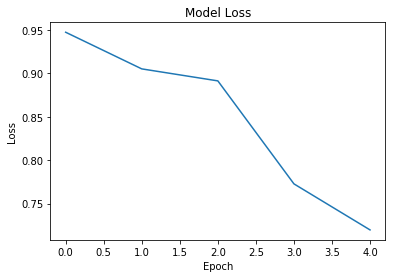

In [16]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

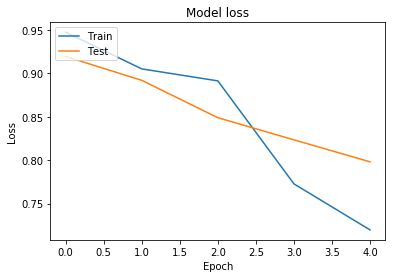

In [17]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
# history.history['acc']

In [14]:
# user_id_input = Input(shape=[1], name='user')
# item_id_input = Input(shape=[1], name='item')

# user_embedding = Embedding(output_dim=100, input_dim=a.shape[0] + 1,
#                                    input_length=1, name='user_embedding')(user_id_input)
# item_embedding = Embedding(output_dim=100, input_dim=a.shape[1] + 1,
#                                    input_length=1, name='item_embedding')(item_id_input)

# # reshape from shape: (batch_size, input_length, embedding_size)
# # to shape: (batch_size, input_length * embedding_size) which is
# # equal to shape: (batch_size, embedding_size)
# user_vecs = Flatten()(user_embedding)
# item_vecs = Flatten()(item_embedding)

#         # y = merge([user_vecs, item_vecs], mode='dot', output_shape=(1,))
# y = dot([user_vecs, item_vecs], axes=1)

# y = Dense

# model = Model(inputs=[user_id_input, item_id_input], outputs=[y])
# model.compile(optimizer='adam', loss='mae',metrics=['accuracy'])

In [15]:
# history = model.fit([Users,Movies], Ratings, batch_size=32, epochs = 5, verbose=1)

In [12]:
def F_20(data_dim, dim_r_new):
    user_id_input = Input(shape=[1], name='user')
    item_id_input = Input(shape=[1], name='item')

    user_embedding = Embedding(output_dim=20, input_dim=data_dim[0] + 1,
                                   input_length=1, name='user_embedding')(user_id_input)
    item_embedding = Embedding(output_dim=20, input_dim=data_dim[1] + 1,
                                   input_length=1, name='item_embedding')(item_id_input)

    user_vecs = (Dense(20))(user_embedding)
    item_vecs = (Dense(20))(item_embedding)
    for i in range(len(dim_u_new)):
        user_vecs = (Dense(dim_u_new[i]))(user_vecs)
        user_vecs = (Dropout(0.25))(user_vecs)
    for i in range(len(dim_i_new)):
        item_vecs = (Dense(dim_i_new[i]))(item_vecs)
        item_vecs = (Dropout(0.25))(item_vecs)

    # reshape from shape: (batch_size, input_length, embedding_size)
    # to shape: (batch_size, input_length * embedding_size) which is
    # equal to shape: (batch_size, embedding_size)
    

    user_vecs = Flatten()(user_embedding)
    item_vecs = Flatten()(item_embedding)

    
    # y = merge([user_vecs, item_vecs], mode='dot', output_shape=(1,))
    y = dot([user_vecs, item_vecs], axes=1)
    for i in range(len(dim_r_new)):
        y = (Dense(dim_r_new[i]))(y)
        y = (Dropout(0.25))(y)
    # y = Dense(1, activation="relu")(y)
    # M = Sequential()
    # M.add(y)
    y = (Dropout(0.4))(y)
    y = (Dense(64))(y)
    # y = (Dropout(0.2))(y)
    y = (Dense(32))(y)
    # y = (Dropout(0.2))(y)
    # y = (Dense(16))(y)
    # y = (Dropout(0.2))(y)
    y = (Dense(4))(y)
    y = (Dense(1, activation='relu'))(y)

    model = Model(inputs=[user_id_input, item_id_input], outputs=[y])
    adam = optimizers.Adam(lr=0.001)
    model.compile(optimizer=adam, loss='mae',metrics=['accuracy', 'mae'])
    return model

In [13]:
dim_u_new = [16,16,32]
dim_i_new = [16,16,32,32]
dim_r_new = [512,256,128,128]
new_m = F_20(data_dim, dim_r_new)

In [67]:
his = new_m.fit([u_train,i_train], r_train,validation_data=([u_test,i_test], r_test), batch_size=64, epochs = 5, verbose=1)

Train on 80000 samples, validate on 20000 samples
Epoch 1/5
80000/80000 [==============================] - 15s 188us/step - loss: 0.9457 - acc: 0.3269 - mean_absolute_error: 0.9457 - val_loss: 0.8164 - val_acc: 0.3856 - val_mean_absolute_error: 0.8164
Epoch 2/5
80000/80000 [==============================] - 12s 149us/step - loss: 0.7400 - acc: 0.4316 - mean_absolute_error: 0.7400 - val_loss: 0.7953 - val_acc: 0.3805 - val_mean_absolute_error: 0.7953
Epoch 3/5
80000/80000 [==============================] - 13s 166us/step - loss: 0.6640 - acc: 0.4827 - mean_absolute_error: 0.6640 - val_loss: 0.7792 - val_acc: 0.3995 - val_mean_absolute_error: 0.7792
Epoch 4/5
80000/80000 [==============================] - 13s 162us/step - loss: 0.6210 - acc: 0.5188 - mean_absolute_error: 0.6210 - val_loss: 0.8210 - val_acc: 0.3817 - val_mean_absolute_error: 0.8210
Epoch 5/5
80000/80000 [==============================] - 12s 151us/step - loss: 0.5949 - acc: 0.5397 - mean_absolute_error: 0.5949 - val_loss:

In [14]:
new_m.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 20)        18880       user[0][0]                       
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 20)        33660       item[0][0]                       
__________________________________________________________________________________________________
flatten_1 

In [15]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot